# Reservas de hoteis

## Contexto
Os canais de reserva de hotéis online mudaram drasticamente as possibilidades de reserva e o comportamento dos clientes. Um número significativo de reservas de hotéis são canceladas devido a cancelamentos ou não comparecimentos. Os motivos típicos para cancelamentos incluem mudança de planos, conflitos de agendamento, etc. Isso geralmente é facilitado pela opção de fazê-lo gratuitamente ou, de preferência, a um baixo custo, o que é benéfico para os hóspedes do hotel, mas é um fator menos desejável e possivelmente de redução de receita para os hotéis lidarem.

#### Você consegue prever se o cliente vai honrar a reserva ou cancelá-la?

## 1. Importações e carregando o Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, silhouette_score


# Carregando o dataset
hotel_data = pd.read_csv("data/hotel_reservations.csv")

## 2. Pré-processamento de dados

#### 2.1 Medindo correlação das features

Primeiramente, precisamos sanitizar nosso dataset visando uma melhor qualidade dos dados

In [2]:
# Removendo colunas de ID e colunas não relevantes para a previsão
hotel_data.drop(columns=['Booking_ID', 'arrival_year', 'arrival_date'], inplace=True)

# Convertendo variáveis categóricas para numéricas
hotel_data = pd.get_dummies(hotel_data, columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], drop_first=True)

# Transformando a variável que queremos prever em numérica: (1: cancelada, 0: não cancelada) 
label_encoder = LabelEncoder()
hotel_data['booking_status'] = label_encoder.fit_transform(hotel_data['booking_status'])

# Normalização de atributos (Excluindo-se a variável de reservas)
scaler = MinMaxScaler()
features_hotel = hotel_data.drop(columns=['booking_status'], errors='ignore')
hotel_data[features_hotel.columns] = scaler.fit_transform(features_hotel)

# Separando features e labels para os dois conjuntos de dados (Treinamento e teste)
#X_hotel = hotel_data.drop(columns=["booking_status"])
#y_hotel = hotel_data["booking_status"]

# Criando a matriz de correlação
correlation_matrix = hotel_data.corr()
    
# Filtrando apenas a correlação com a variavel de Status de Reserva
cor_target = correlation_matrix["booking_status"].drop("booking_status")

# Ordenando da maior para a menor correlação absoluta
cor_target_sorted = cor_target.abs().sort_values(ascending=False)
print(cor_target_sorted)


lead_time                               0.438538
no_of_special_requests                  0.253070
avg_price_per_room                      0.142569
market_segment_type_Corporate           0.112993
repeated_guest                          0.107287
market_segment_type_Online              0.106362
no_of_week_nights                       0.092996
no_of_adults                            0.086920
type_of_meal_plan_Meal Plan 2           0.086370
required_car_parking_space              0.086185
market_segment_type_Complementary       0.072867
no_of_weekend_nights                    0.061563
no_of_previous_bookings_not_canceled    0.060179
market_segment_type_Offline             0.038351
no_of_previous_cancellations            0.033728
no_of_children                          0.033078
room_type_reserved_Room_Type 6          0.032652
room_type_reserved_Room_Type 7          0.014062
room_type_reserved_Room_Type 4          0.013309
arrival_month                           0.011233
room_type_reserved_R

Analisando o resultado da medição de correlação podemos identificar que as seguintes colunas: room_type_reserved_Room_Type 3, room_type_reserved_Room_Type 2, type_of_meal_plan_Meal Plan 3, type_of_meal_plan_Not Selected e room_type_reserved_Room_Type 5 podem ser removidas devido à apresentarem uma correlação insignificante (> 0.1) com a coluna que queremos prever.

In [3]:
#Definindo a nossa nova base de dados processada
hotel_data_processed = hotel_data.drop(columns=['room_type_reserved_Room_Type 2',
                                        'type_of_meal_plan_Meal Plan 3', 
                                        'room_type_reserved_Room_Type 3', 
                                        'type_of_meal_plan_Not Selected',
                                        'room_type_reserved_Room_Type 5'])

#### 2.2 Exibição dos dados processados


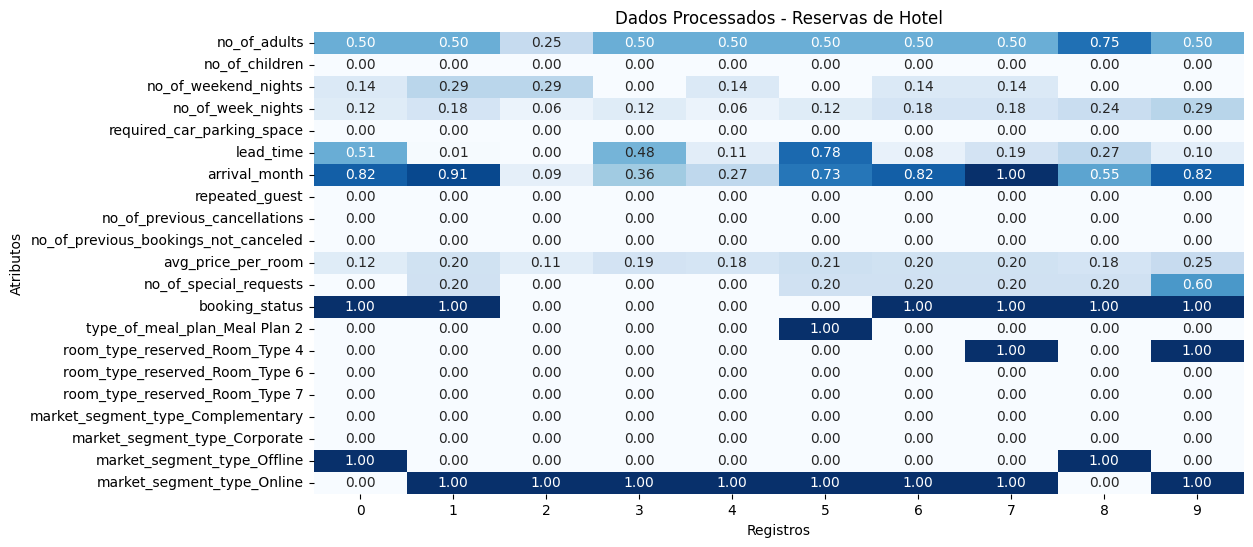

In [4]:
def plot_table(df, title):
    transposed_df = df.head(10).T
    plt.figure(figsize=(12, 6))
    sns.heatmap(transposed_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Registros")
    plt.ylabel("Atributos")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()

plot_table(hotel_data_processed, "Dados Processados - Reservas de Hotel")

## 3. Definindo a validação cruzada

In [5]:
# Definindo o número de folds
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Separando features e labels para os dois conjuntos de dados (Treinamento e teste)
X_hotel = hotel_data_processed.drop(columns=["booking_status"])
y_hotel = hotel_data_processed["booking_status"]

# Criando os folds
folds_hotel = list(skf.split(X_hotel, y_hotel))
print(f"Criados {k} folds para o dataset")


Criados 10 folds para o dataset


## 4. Árvores de decisão

Em primeiro momento vamos testar a classificação utilizando os parâmetros default da árvore apenas alterando o seu critério de classificação entre Gini e Entropy

#### 4.1 Treinamento e validação

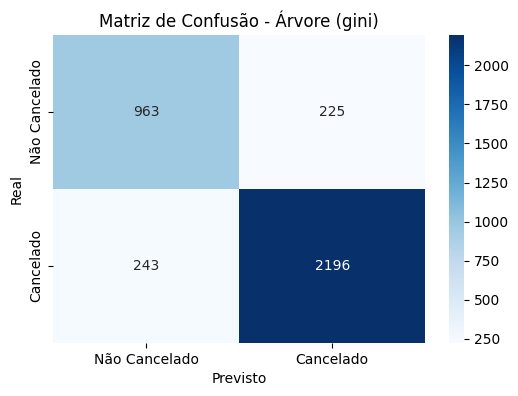

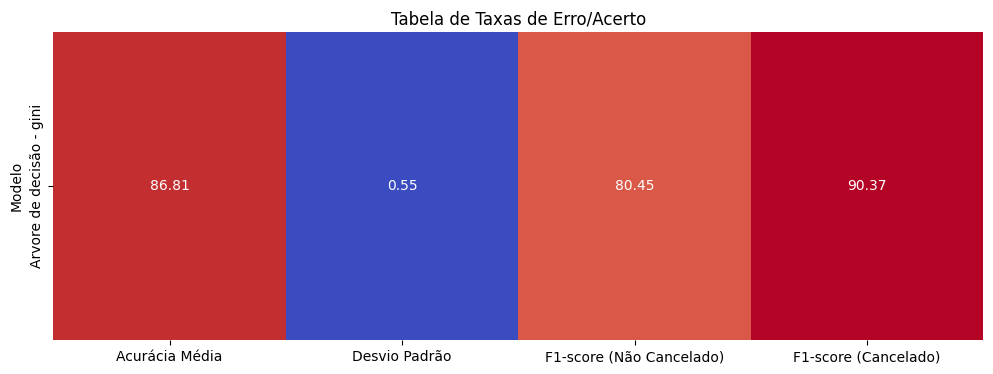

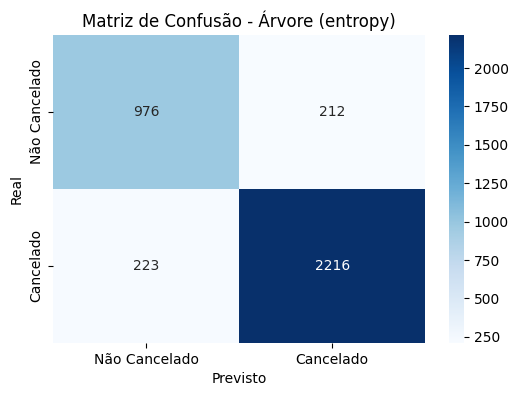

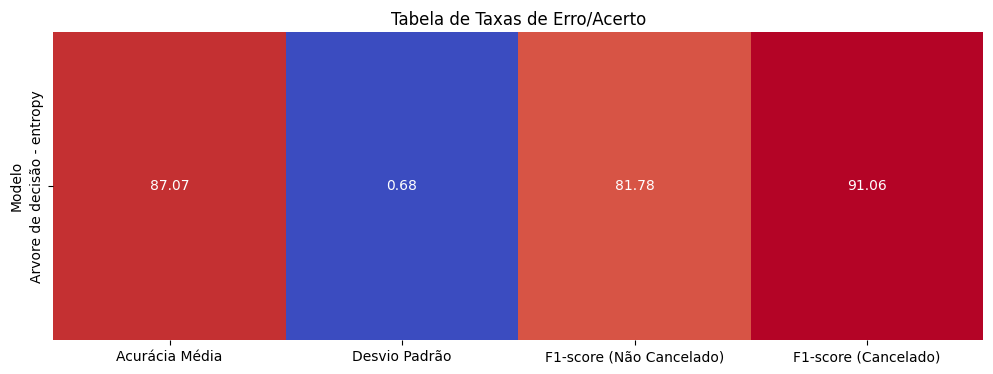

In [6]:

# Definindo os critérios
criterios = ["gini", "entropy"]

resultados_hotel_arvore = {}

# Treinamento, teste e avaliação do modelo
for criterio in criterios:
    accuracies = []

    for train_idx, test_idx in skf.split(X_hotel, y_hotel):
        X_train, X_test = X_hotel.iloc[train_idx], X_hotel.iloc[test_idx]
        y_train, y_test = y_hotel.iloc[train_idx], y_hotel.iloc[test_idx]

        modelo = DecisionTreeClassifier(criterion=criterio, random_state=42)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))

    # Acurácia
    mean_accuracy = np.mean(accuracies) * 100
    std_accuracy = np.std(accuracies) * 100
    
    #Treinamento do ultimo fold
    last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
    X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
    y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # F1-score
    f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100  # "Não cancelado"
    f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100  # "Cancelado"

    # Resultados
    resultados_arvore = {
        "Modelo": [f"Arvore de decisão - {criterio}"],
        "Acurácia Média": [mean_accuracy],
        "Desvio Padrão": [std_accuracy],
        "F1-score (Não Cancelado)": [f1_0],
        "F1-score (Cancelado)": [f1_1]
    }

    df_resultados_arvore = pd.DataFrame(resultados_arvore)
    df_resultados_arvore.set_index("Modelo", inplace=True)

    # matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - Árvore ({criterio})")
    plt.show()

    # Resultados
    plt.figure(figsize=(12, 4))
    sns.heatmap(df_resultados_arvore, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title("Tabela de Taxas de Erro/Acerto")
    plt.show()



Aproximadamente 87% de acurácia é um bom valor mas acredito que podemos chegar a um valor de acurácia maior. Em primeiro momento vamos utilizar um algoritmo para encontrar os melhores parâmetros de acordo com o nosso problema.

#### 4.2 Tunning de Parâmetros

In [7]:
#Utilizando o GriSearchCV para encontrar os parâmetros que mais se encaixam com o nosso dataset

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_hotel, y_hotel)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia encontrada:", f"{grid_search.best_score_ * 100:.2f}", "%")


KeyboardInterrupt: 

## 5. KNN

Agora que utilizamos o modelo de árvore de decisão vamos usar o knn com duas versões uma com K sendo 5 e outra com K sendo igual a 10.


#### 5.1 Treinamento e validação

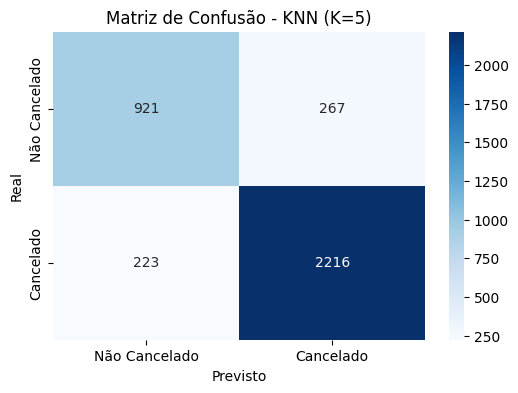

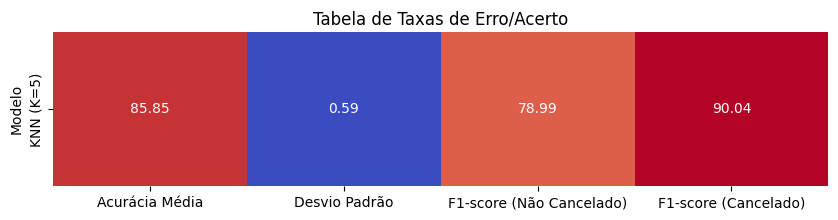

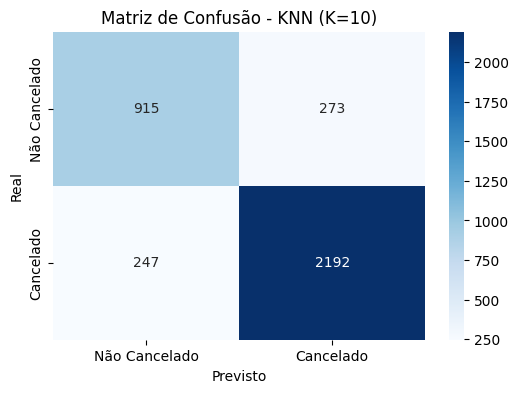

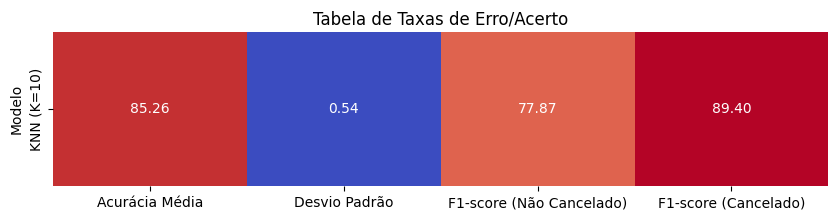

In [23]:
K_values = [5, 10]
resultados_hotel_knn = {}

for k in K_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Validação cruzada
    accuracies = cross_val_score(knn_model, X_hotel, y_hotel, cv=skf, scoring="accuracy")

    # Média e desvio padrão da acurácia
    mean_accuracy = np.mean(accuracies) * 100
    std_accuracy = np.std(accuracies) * 100

    # Treinamento e teste do ultimo fold
    last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
    X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
    y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    # Calculando f1
    f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100  # "Não cancelado"
    f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100  # "Cancelado"

    # Resultados
    resultados_hotel_knn = {
        "Modelo": [f"KNN (K={k})"],
        "Acurácia Média": [mean_accuracy],
        "Desvio Padrão": [std_accuracy],
        "F1-score (Não Cancelado)": [f1_0],
        "F1-score (Cancelado)": [f1_1]
    }

    df_resultados_knn = pd.DataFrame(resultados_hotel_knn)
    df_resultados_knn.set_index("Modelo", inplace=True)

    # Exibindo a matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - KNN (K={k})")
    plt.show()

    # Resultados
    plt.figure(figsize=(10, 2))
    sns.heatmap(df_resultados_knn, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title("Tabela de Taxas de Erro/Acerto")
    plt.show()



## 6. MLP

Agora vamos utilizar o modelo MLP variando entre 2 arquiteturas.

1. MLP 1:
    - Arquitetura com camadas ocultas de 50 e 25 neurônios

2. MLP 2:
    - Arquitetura com camadas ocultas de 100 e 50 neurônios

_Alem disso vamos alternar entre os parâmetros de ativação *relu* e *tanh*_

### 6.1 Treinamento e validação

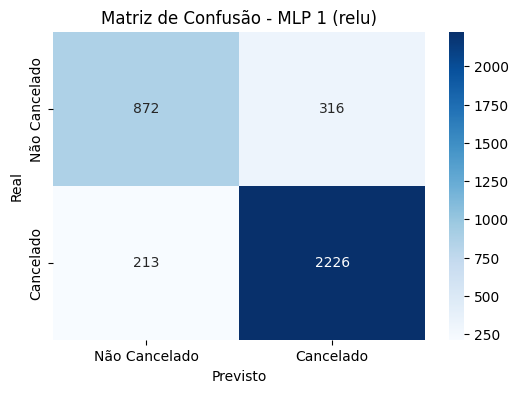

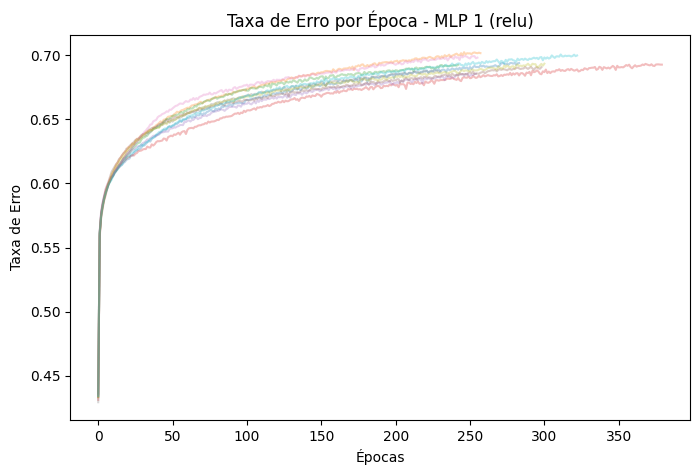

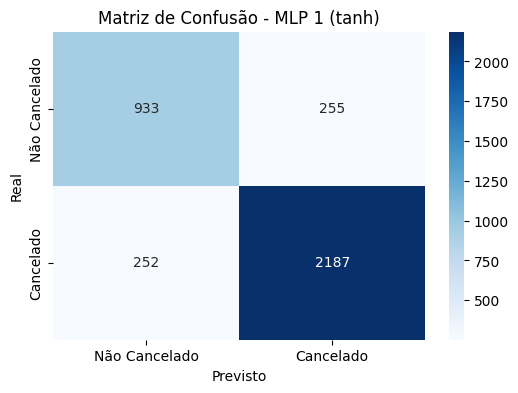

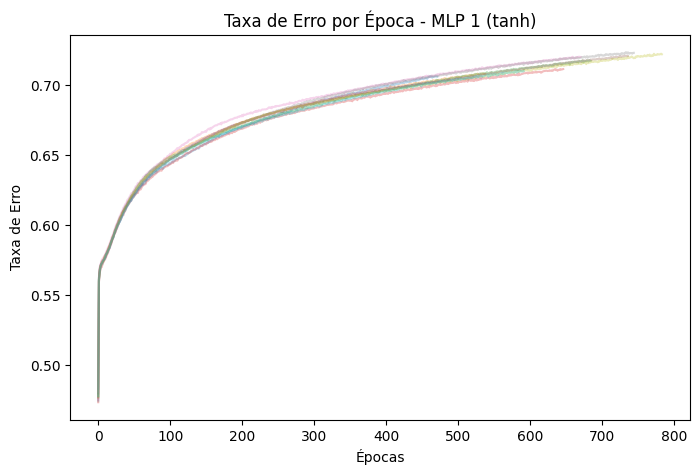

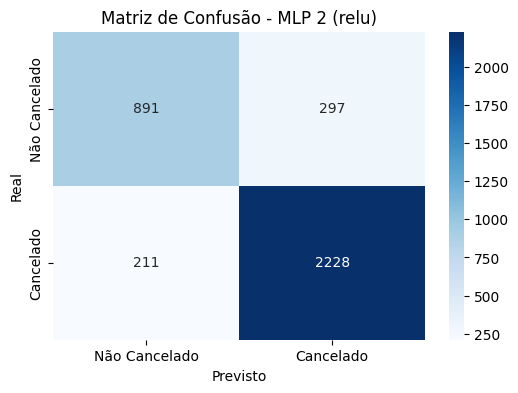

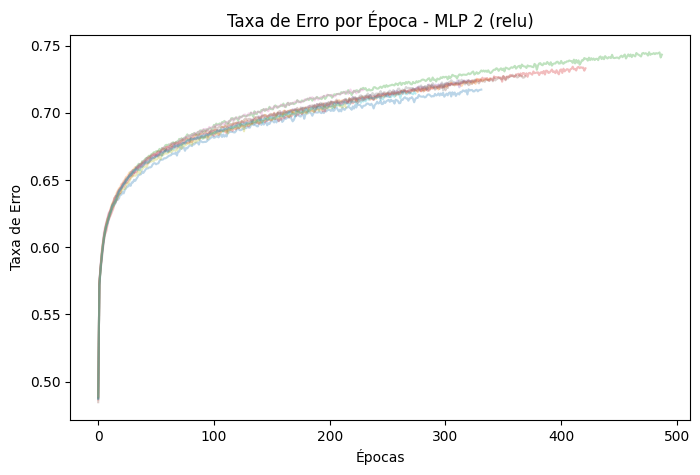

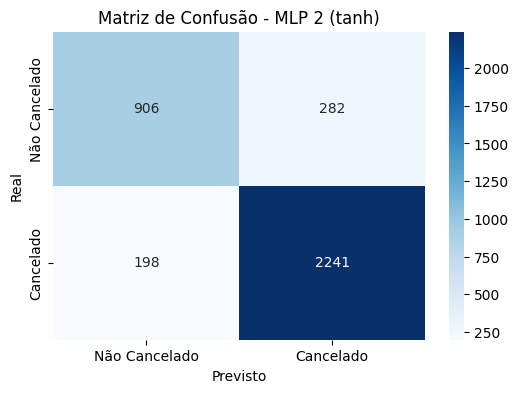

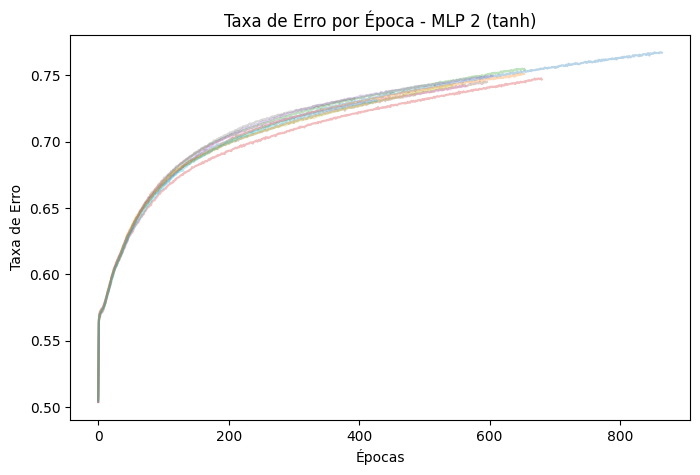


Resultados da MLP (k-fold cross-validation):
             Acurácia Média Desvio Padrão F1-score (Não Cancelado)  \
MLP 1 (relu)         85.23%         0.78%                   76.73%   
MLP 1 (tanh)         86.14%         0.68%                   78.63%   
MLP 2 (relu)         85.95%         0.73%                   77.82%   
MLP 2 (tanh)         86.34%         0.66%                   79.06%   

             F1-score (Cancelado)  
MLP 1 (relu)               89.38%  
MLP 1 (tanh)               89.61%  
MLP 2 (relu)               89.77%  
MLP 2 (tanh)               90.33%  


In [ ]:
# Definindo arquiteturas
arquiteturas = {
    "MLP 1": (50, 25),
    "MLP 2": (100, 50)
}

# Parâmetros de ativação
ativacoes = ["relu", "tanh"]

# Dicionário de resultados
resultados_mlp = {}


# Treinamento, teste e avaliação dos modelos
for nome_arquitetura, camadas in arquiteturas.items():
    for ativacao in ativacoes:
        acuracias = []

        erro_por_epoca = []

        for train_idx, test_idx in skf.split(X_hotel, y_hotel):
            X_train, X_test = X_hotel.iloc[train_idx], X_hotel.iloc[test_idx]
            y_train, y_test = y_hotel.iloc[train_idx], y_hotel.iloc[test_idx]

            modelo = MLPClassifier(hidden_layer_sizes=camadas, activation=ativacao, max_iter=2000, random_state=42)
            modelo.fit(X_train, y_train)

            # Taxa de erros por epoca
            erro_por_epoca.append(1 - np.array(modelo.loss_curve_))

            y_pred = modelo.predict(X_test)

            acuracias.append(accuracy_score(y_test, y_pred))

        # Acurácia
        mean_accuracy = np.mean(acuracias) * 100
        std_accuracy = np.std(acuracias) * 100

        # Validação do ultimo fold
        last_train_idx, last_test_idx = list(skf.split(X_hotel, y_hotel))[-1]
        X_train, X_test = X_hotel.iloc[last_train_idx], X_hotel.iloc[last_test_idx]
        y_train, y_test = y_hotel.iloc[last_train_idx], y_hotel.iloc[last_test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # F1-score
        f1_0 = f1_score(y_test, y_pred, pos_label=0) * 100
        f1_1 = f1_score(y_test, y_pred, pos_label=1) * 100

        # Resultados
        chave = f"{nome_arquitetura} ({ativacao})"
        resultados_mlp[chave] = {
            "Acurácia Média": f"{mean_accuracy:.2f}%",
            "Desvio Padrão": f"{std_accuracy:.2f}%",
            "F1-score (Não Cancelado)": f"{f1_0:.2f}%",
            "F1-score (Cancelado)": f"{f1_1:.2f}%"
        }

        #Data frame
        df_resultados_mlp = pd.DataFrame(resultados_mlp).T

        # Matriz de confusão
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
        plt.xlabel("Previsto")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {chave}")
        plt.show()

        # Gráficos de erro por epoca
        plt.figure(figsize=(8, 5))
        for erro in erro_por_epoca:
            plt.plot(erro, alpha=0.3)
        plt.xlabel("Épocas")
        plt.ylabel("Taxa de Erro")
        plt.title(f"Taxa de Erro por Época - {chave}")
        plt.show()

        # Resultados
        plt.figure(figsize=(10, 2))
        sns.heatmap(df_resultados_mlp, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
        plt.title("Tabela de Taxas de Erro/Acerto")
        plt.show()


## 7. K-MEANS

Agora para nosso ultimo modelo utilizaremos o K-means. Como estamos tentando fazer uma previsão binária onde 1 = Cancelado e 0 = Não cancelado nosso K será igual à 2.

#### 7.1 Treinamento do K-MEANS

Distribuição das classes nos clusters:
Cluster 0: {0: 6814, 1: 11824}
Cluster 1: {0: 2694, 1: 7688}
Silhouette Score para K=2: 0.4368


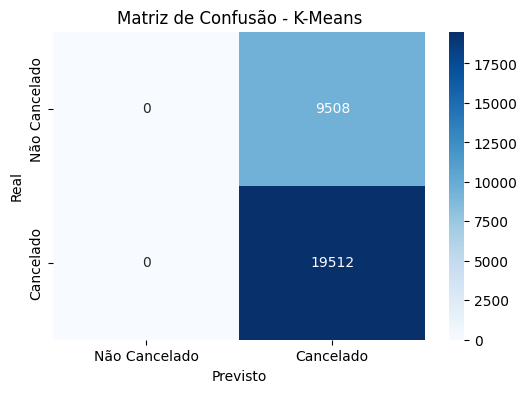

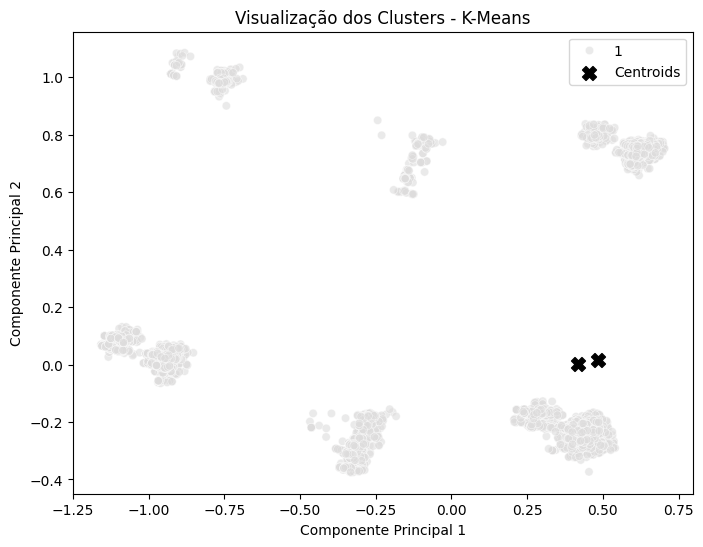

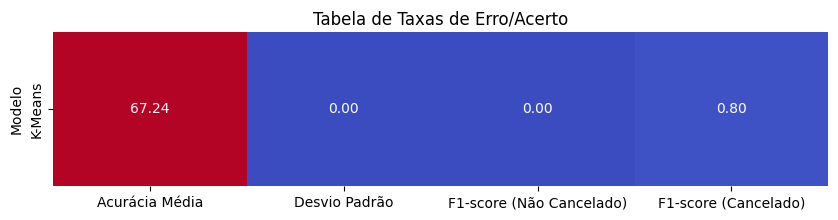

In [6]:
# Clusters
K = 2

# Divisão das bases de teste e treinamento
X_train, x_test, Y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, stratify=y_hotel)

# Treinamento 
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(X_train)

# Rotulos dos clusters
cluster_labels = kmeans.labels_

# Verificando a distribuição das classes nos clusters
distribution = {i: Counter(Y_train.iloc[cluster_labels == i]) for i in range(K)}
print("Distribuição das classes nos clusters:")
for cluster, dist in distribution.items():
    print(f"Cluster {cluster}: {dict(dist)}")

# mapeando clusters
map_labels = [[] for _ in range(K)]

for i in range(len(Y_train)):
    cluster_idx = cluster_labels[i]
    map_labels[cluster_idx].append(Y_train.iloc[i])

# Mapeando de acordo com a classe mais comum de cada cluster (Verificando antes a proporção)
mapping = {}
for i in range(K):
    most_common_class = Counter(map_labels[i]).most_common(1)[0][0]
    if most_common_class == 1:
        mapping[i] = 1  # "Cancelado"
    else:
        mapping[i] = 0  # "Não Cancelado"


# Aplicando o mapeamento aos rótulos
mapped_labels = np.array([mapping[label] for label in cluster_labels])

# Acurácia
mean_accuracy = accuracy_score(Y_train, mapped_labels) * 100
std_accuracy = np.std(mapped_labels) * 100

# F1-score
f1_0 = f1_score(Y_train, mapped_labels, pos_label=0)  # "Não Cancelado"
f1_1 = f1_score(Y_train, mapped_labels, pos_label=1)  # "Cancelado"

# Silhouette Score
score = silhouette_score(X_train, kmeans.labels_)
print(f"Silhouette Score para K=2: {score:.4f}")

# Resultados
resultados_kmeans = {
    "Modelo": ["K-Means"],
    "Acurácia Média": [mean_accuracy],
    "Desvio Padrão": [std_accuracy],
    "F1-score (Não Cancelado)": [f1_0],
    "F1-score (Cancelado)": [f1_1]
}

# Dataframe
df_resultados_kmeans = pd.DataFrame(resultados_kmeans)
df_resultados_kmeans.set_index("Modelo", inplace=True)

# Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(Y_train, mapped_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - K-Means")
plt.show()

# PCA para visualização
df_pca = PCA(n_components=2)
X_pca = df_pca.fit_transform(X_train)

# Agrupamento dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=mapped_labels, palette="coolwarm", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='X', s=100, label='Centroids')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualização dos Clusters - K-Means")
plt.legend()
plt.show()

# Resultados
plt.figure(figsize=(10, 2))
sns.heatmap(df_resultados_kmeans, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Tabela de Taxas de Erro/Acerto")
plt.show()


#### 7.2 Teste do K-MEANS

Silhouette Score para K=2 (teste): 0.4369


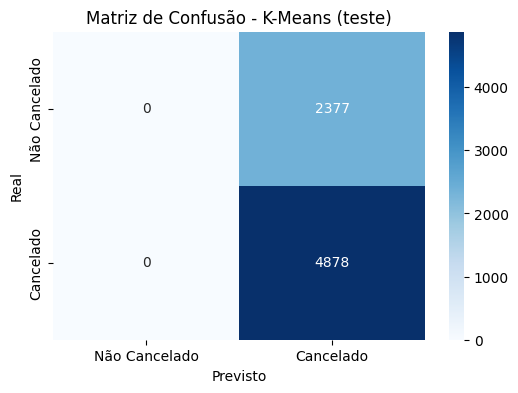

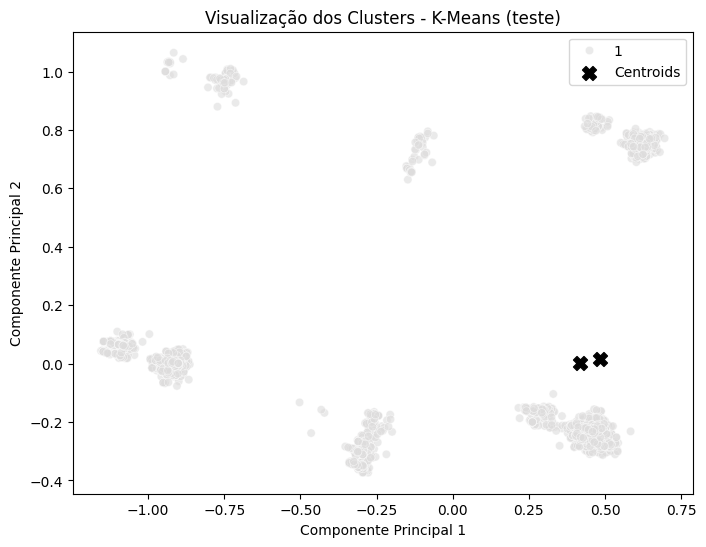

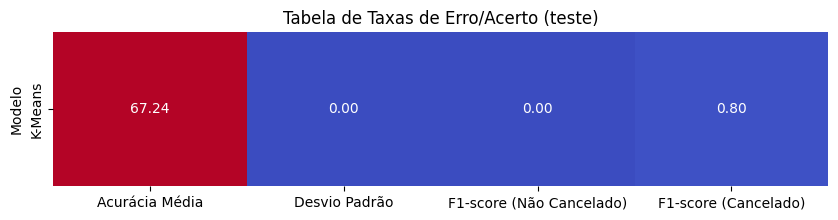

In [10]:
# Predição
cluster_labels_test = kmeans.predict(x_test)

# Mapeando os rótulos dos clusters para as classes no conjunto de teste
mapped_labels_test = np.array([mapping[label] for label in cluster_labels_test])

# Acurácia
mean_accuracy = accuracy_score(y_test, mapped_labels_test) * 100
std_accuracy = np.std(mapped_labels) * 100

# F1-score
f1_0 = f1_score(y_test, mapped_labels_test, pos_label=0)  # "Não Cancelado"
f1_1 = f1_score(y_test, mapped_labels_test, pos_label=1)  # "Cancelado"

# Silhouette Score
score = silhouette_score(x_test, cluster_labels_test)
print(f"Silhouette Score para K=2 (teste): {score:.4f}")

# Resultados
resultados_kmeans = {
    "Modelo": ["K-Means"],
    "Acurácia Média": [mean_accuracy],
    "Desvio Padrão": [std_accuracy],
    "F1-score (Não Cancelado)": [f1_0],
    "F1-score (Cancelado)": [f1_1]
}

# Dataframe
df_resultados_kmeans = pd.DataFrame(resultados_kmeans)
df_resultados_kmeans.set_index("Modelo", inplace=True)

# Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, mapped_labels_test), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - K-Means (teste)")
plt.show()

# PCA para visualização
df_pca = PCA(n_components=2)
X_pca = df_pca.fit_transform(x_test)

# Agrupamento dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=mapped_labels_test, palette="coolwarm", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='X', s=100, label='Centroids')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualização dos Clusters - K-Means (teste)")
plt.legend()
plt.show()

# Resultados
plt.figure(figsize=(10, 2))
sns.heatmap(df_resultados_kmeans, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Tabela de Taxas de Erro/Acerto (teste)")
plt.show()

Nosso dataset possui uma proporção de aproximadamente 70:30 entre as duas classes que estamos tentando prever. O que está ocorrendo é que o K-means, ao tentar separar as classes nos clusters, acaba realizando a predição com base na classe predominante dentro de cada cluster. Devido à dispariedade da proporção entre as classes, a classe majoritária (70%) acaba sendo predominante em ambos os clusters, o que afeta a qualidade da predição. Vamos tentar resolver isso utilizando a técnica de Downscalling para balancear os dados.

#### 7.3 Downscalling dos dados

##### 7.3.1 Treinamento

Distribuição das classes nos clusters:
Cluster 0: {0: 6813, 1: 5809}
Cluster 1: {0: 2695, 1: 3699}
Silhouette Score para K=2: 0.4473


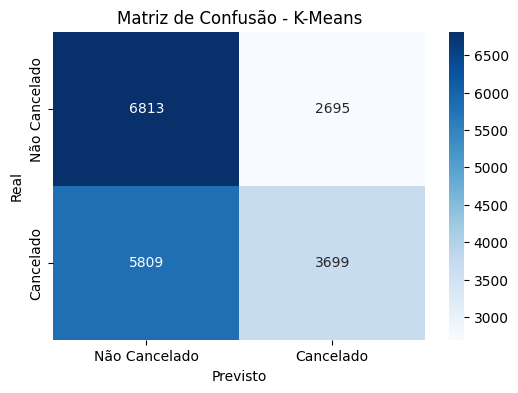

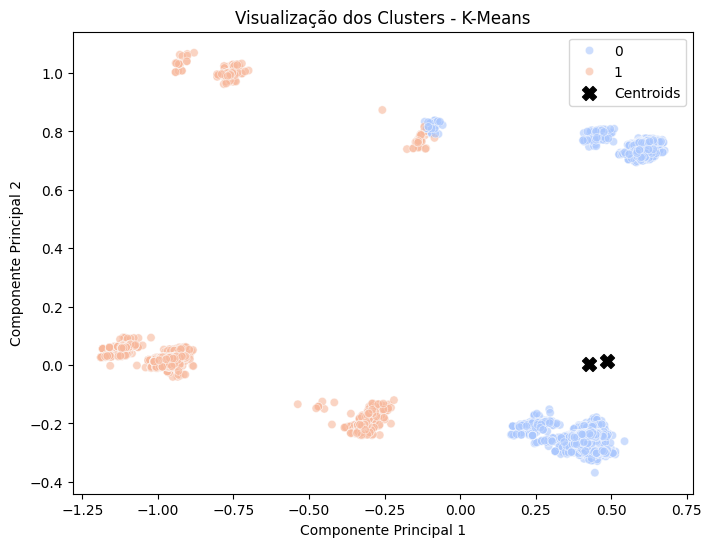

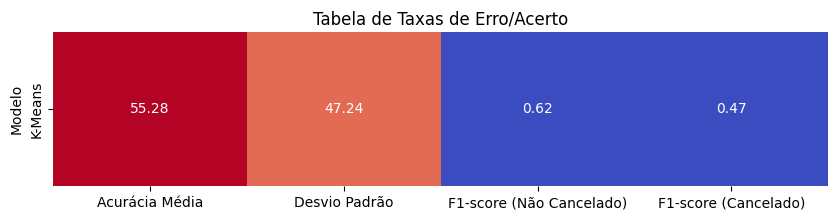

In [19]:
# Downscalling e treinamento com o novo dataset
X_train, x_test, Y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, stratify=y_hotel)

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)
x_test_resampled, y_test_resampled = undersampler.fit_resample(x_test, y_test)

kmeans.fit(X_train_resampled)

# Rotulos dos clusters
cluster_labels = kmeans.labels_

# Verificando a distribuição das classes nos clusters
distribution = {i: Counter(Y_train_resampled.iloc[cluster_labels == i]) for i in range(K)}
print("Distribuição das classes nos clusters:")
for cluster, dist in distribution.items():
    print(f"Cluster {cluster}: {dict(dist)}")

# mapeando clusters
map_labels = [[] for _ in range(K)]

for i in range(len(Y_train_resampled)):
    cluster_idx = cluster_labels[i]
    map_labels[cluster_idx].append(Y_train_resampled.iloc[i])

# Mapeando de acordo com a classe mais comum de cada cluster (Verificando antes a proporção)
mapping = {}
for i in range(K):
    most_common_class = Counter(map_labels[i]).most_common(1)[0][0]
    if most_common_class == 1:
        mapping[i] = 1  # "Cancelado"
    else:
        mapping[i] = 0  # "Não Cancelado"


# Aplicando o mapeamento aos rótulos
mapped_labels = np.array([mapping[label] for label in cluster_labels])

# Acurácia
mean_accuracy = accuracy_score(Y_train_resampled, mapped_labels) * 100
std_accuracy = np.std(mapped_labels) * 100

# F1-score
f1_0 = f1_score(Y_train_resampled, mapped_labels, pos_label=0)  # "Não Cancelado"
f1_1 = f1_score(Y_train_resampled, mapped_labels, pos_label=1)  # "Cancelado"

# Silhouette Score
score = silhouette_score(X_train_resampled, kmeans.labels_)
print(f"Silhouette Score para K=2: {score:.4f}")

# Resultados
resultados_kmeans = {
    "Modelo": ["K-Means"],
    "Acurácia Média": [mean_accuracy],
    "Desvio Padrão": [std_accuracy],
    "F1-score (Não Cancelado)": [f1_0],
    "F1-score (Cancelado)": [f1_1]
}

# Dataframe
df_resultados_kmeans = pd.DataFrame(resultados_kmeans)
df_resultados_kmeans.set_index("Modelo", inplace=True)

# Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(Y_train_resampled, mapped_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - K-Means")
plt.show()

# PCA para visualização
df_pca = PCA(n_components=2)
X_pca = df_pca.fit_transform(X_train_resampled)

# Agrupamento dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=mapped_labels, palette="coolwarm", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='X', s=100, label='Centroids')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualização dos Clusters - K-Means")
plt.legend()
plt.show()

# Resultados
plt.figure(figsize=(10, 2))
sns.heatmap(df_resultados_kmeans, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Tabela de Taxas de Erro/Acerto")
plt.show()

##### 7.3.2 Teste

Silhouette Score para K=2 nos dados de teste: 0.4380


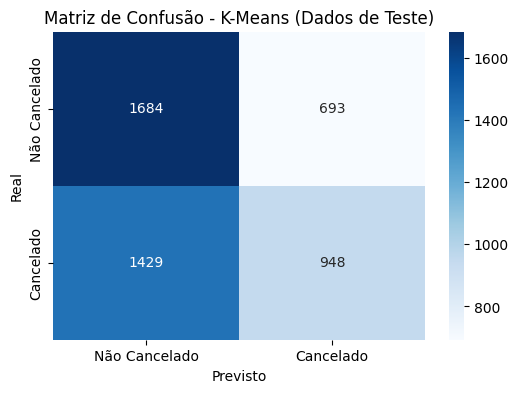

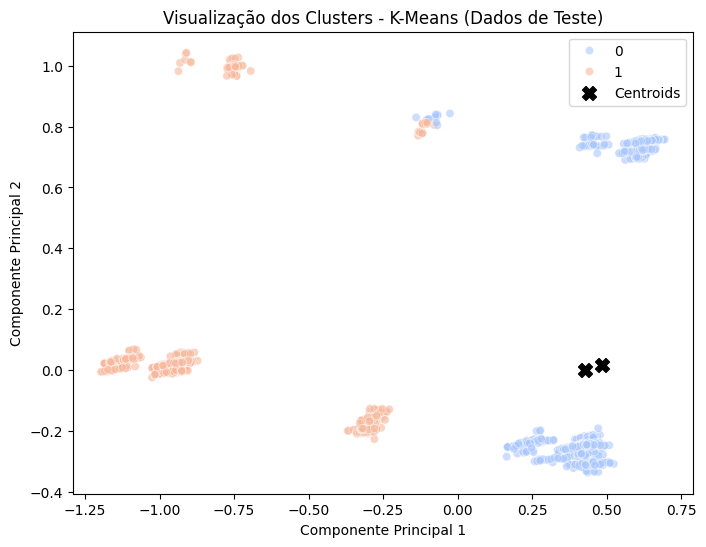

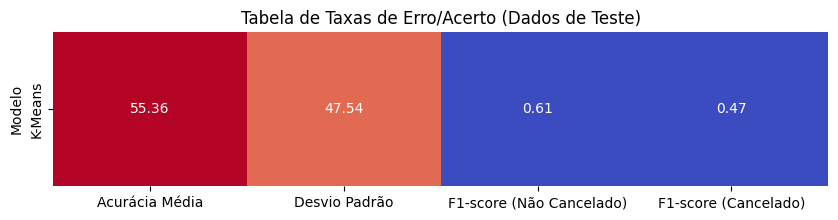

In [21]:
# Predição nos dados de teste
cluster_labels_test = kmeans.predict(x_test_resampled)

# Mapeando os rótulos dos clusters para as classes no conjunto de teste
mapped_labels_test = np.array([mapping[label] for label in cluster_labels_test])

# Acurácia nos dados de teste
mean_accuracy_test = accuracy_score(y_test_resampled, mapped_labels_test) * 100
std_accuracy_test = np.std(mapped_labels_test) * 100

# F1-score nos dados de teste
f1_0_test = f1_score(y_test_resampled, mapped_labels_test, pos_label=0)  # "Não Cancelado"
f1_1_test = f1_score(y_test_resampled, mapped_labels_test, pos_label=1)  # "Cancelado"

# Silhouette Score nos dados de teste
score_test = silhouette_score(x_test_resampled, cluster_labels_test)
print(f"Silhouette Score para K=2 nos dados de teste: {score_test:.4f}")

# Resultados para os dados de teste
resultados_kmeans_test = {
    "Modelo": ["K-Means"],
    "Acurácia Média": [mean_accuracy_test],
    "Desvio Padrão": [std_accuracy_test],
    "F1-score (Não Cancelado)": [f1_0_test],
    "F1-score (Cancelado)": [f1_1_test]
}

# Dataframe
df_resultados_kmeans_test = pd.DataFrame(resultados_kmeans_test)
df_resultados_kmeans_test.set_index("Modelo", inplace=True)

# Matriz de confusão para os dados de teste
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, mapped_labels_test), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Cancelado", "Cancelado"], yticklabels=["Não Cancelado", "Cancelado"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - K-Means (Dados de Teste)")
plt.show()

# PCA para visualização nos dados de teste
df_pca_test = PCA(n_components=2)
X_pca_test = df_pca_test.fit_transform(x_test_resampled)

# Agrupamento dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_test[:, 0], y=X_pca_test[:, 1], hue=mapped_labels_test, palette="coolwarm", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='X', s=100, label='Centroids')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualização dos Clusters - K-Means (Dados de Teste)")
plt.legend()
plt.show()

# Resultados para os dados de teste
plt.figure(figsize=(10, 2))
sns.heatmap(df_resultados_kmeans_test, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Tabela de Taxas de Erro/Acerto (Dados de Teste)")
plt.show()
